In [1]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from my_utils import Utils
import glob
import re
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
from my_utils import Utils
import torch
import csv
import pandas as pd
import seaborn as sns
import fnmatch
import matplotlib.pyplot as plt
from my_utils import AllStainUtils

/tmp/ipykernel_535086/2697172764.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
mask_dir='/nfs2/baos1/rudravg/Retention_Masks'
tissue_path='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered'
tissue_name='GCA002ACB'

Getting the mask file


In [3]:
for file in os.listdir(mask_dir):
    if fnmatch.fnmatch(file, '*{}*'.format(tissue_name)):
        mask_path=os.path.join(mask_dir, file)

All Tissues

In [4]:
all_tissues=[]
for file in os.listdir(tissue_path):
    if fnmatch.fnmatch(file, '*.tif'):
        all_tissues.append(os.path.join(tissue_path, file))

In [5]:
def sort_key(file_name):
    match = re.search(r'ROUND_(\d+)', file_name)
    if match:
        return int(match.group(1))
    else:
        return 0

# Sort the file names
sorted_file_names = sorted(all_tissues, key=sort_key)

print(sorted_file_names)

['/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_DAPI_UV_12ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_SNA_Cy5_200ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_COLLAGEN_Cy3_15ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_MUC2_GFP_100ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_AF_Cy3_15ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_DAPI_UV_12ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_AF_GFP_100ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_AF_Cy5_200ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002A

In [6]:
# Break the sorted file names into sets of 4
rounds = [sorted_file_names[i:i+4] for i in range(0, len(sorted_file_names), 4)]

# Store each set in a different array and ensure 'DAPI' is the first element
for i, round in enumerate(rounds):
    round.sort(key=lambda x: 'DAPI' not in x)
    globals()[f'Round_{i+1}'] = round

# Print the arrays
for i in range(1, len(rounds)+1):
    print(f'Round_{i}:', globals()[f'Round_{i}'])

Round_1: ['/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_DAPI_UV_12ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_SNA_Cy5_200ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_COLLAGEN_Cy3_15ms_ROUND_00.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_MUC2_GFP_100ms_ROUND_00.tif']
Round_2: ['/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_DAPI_UV_12ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_AF_Cy3_15ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_AF_GFP_100ms_ROUND_01.tif', '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_AF_Cy5_200ms_ROUND_01.tif']
Round_3: ['/fs5/p_masi/baos1/rudravg/MXIF/MXI

In [7]:
DAPI_round_0=rounds[0][0]

In [8]:
for round in rounds:
    DAPI_roundx=round[0]
    stain1=round[1]
    stain2=round[2]
    stain3=round[3]
    print(DAPI_roundx, stain1, stain2, stain3)
    break

/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_DAPI_UV_12ms_ROUND_00.tif /fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_SNA_Cy5_200ms_ROUND_00.tif /fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_COLLAGEN_Cy3_15ms_ROUND_00.tif /fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/GCA002ACB_MUC2_GFP_100ms_ROUND_00.tif


In [9]:
round0,roundx,stain1,stain2,stain3,mask=AllStainUtils.load_all_stains_and_dapi(DAPI_round_0, DAPI_roundx, stain1, stain2, stain3, mask_path)

[  0 255]
[0 1]


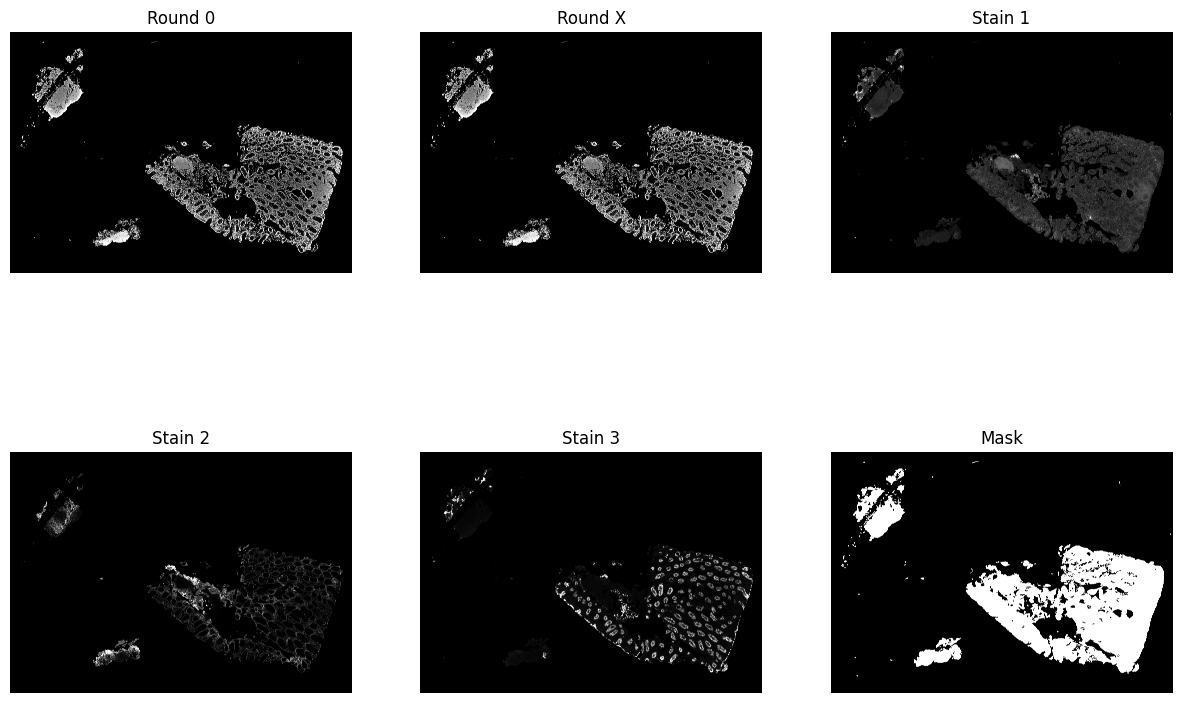

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Display the images
axs[0, 0].imshow(round0, cmap='gray')
axs[0, 0].set_title('Round 0')
axs[0, 1].imshow(roundx, cmap='gray')
axs[0, 1].set_title('Round X')
axs[0, 2].imshow(stain1, cmap='gray')
axs[0, 2].set_title('Stain 1')
axs[1, 0].imshow(stain2, cmap='gray')
axs[1, 0].set_title('Stain 2')
axs[1, 1].imshow(stain3, cmap='gray')
axs[1, 1].set_title('Stain 3')
axs[1, 2].imshow(mask, cmap='gray')
axs[1, 2].set_title('Mask')

# Remove axis
for ax in axs.flat:
    ax.axis('off')

plt.show()

***How to apply the transformation from DAPI on the other image:***


(Special Thanks to Past Myself for figuring this out earlier and saving me the mental stress)


moved_np1 = vxm.py.utils.load_volfile('/home-local/rudravg/test_DAPI/testing_it_out/moved_np1v1.npy', add_batch_axis=True, add_feat_axis=True)


moved_np1 = torch.from_numpy(moved_np1).to(device).float().permute(0,3,1,2)


composed_moved = best_model.transformer(moved_np1, torch.from_numpy(warp2).to(device))


composed_moved_np = composed_moved.detach().cpu().numpy()

In [11]:
model_path='/home-local/rudravg/test_DAPI/epochs/epoch_35/epoch_35.pth'
model,device=Utils.load_model(model_path)
device='cuda:0'
model.to(device)
model.eval()

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [12]:
(recon_tissue, recon_stain1, recon_stain2, recon_stain3) = AllStainUtils.do_registration(
    fixed=round0, 
    moving_img=roundx, 
    stain1=stain1,
    stain2=stain2, 
    stain3=stain3, 
    model=model,
    device=device
)

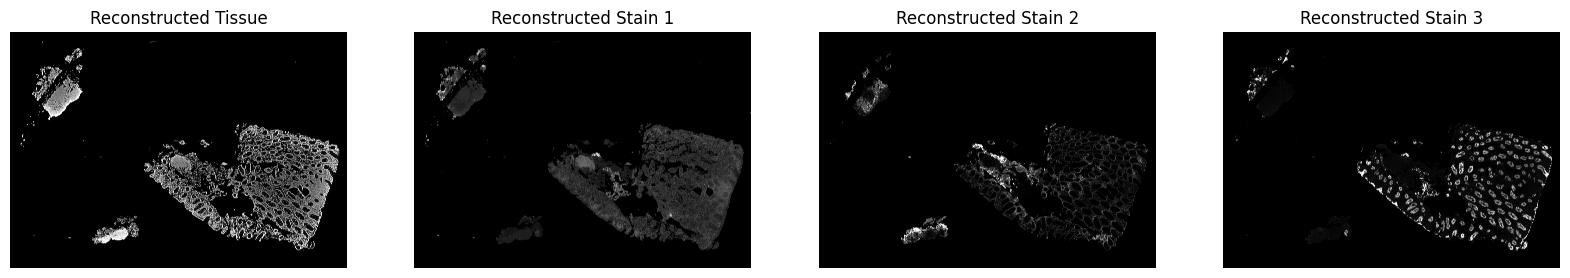

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Display the images
axs[0].imshow(recon_tissue, cmap='gray')
axs[0].set_title('Reconstructed Tissue')
axs[1].imshow(recon_stain1, cmap='gray')
axs[1].set_title('Reconstructed Stain 1')
axs[2].imshow(recon_stain2, cmap='gray')
axs[2].set_title('Reconstructed Stain 2')
axs[3].imshow(recon_stain3, cmap='gray')
axs[3].set_title('Reconstructed Stain 3')

# Remove axis
for ax in axs.flat:
    ax.axis('off')

plt.show()